# Apartment Data

This notebook create new features and mesures the the perfomance change in the model. The goal is to create features to increase the model performance.

In [45]:
# Libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Import the data

In [46]:
# Read the data to a pandas data frame
df = pd.read_csv('original_apartment_data_analytics_hs24_with_lat_lon.csv', sep=',', encoding='utf-8')
# Get number of rows and columns
df.shape

# Add Distance to Lake Zurich Feature
from geopy.distance import geodesic

# Define Lake Zurich reference point (Bürkliplatz)
lake_zurich = (47.3663, 8.5417)

# Function to compute distance to Lake Zurich
def distance_to_lake(lat, lon):
    return geodesic((lat, lon), lake_zurich).km

# Compute and add feature to dataset
df["distance_to_lake"] = df.apply(lambda row: distance_to_lake(row["lat"], row["lon"]), axis=1)

# Check if the feature was added correctly
df[['lat', 'lon', 'distance_to_lake']].head()

# Textbasierte Features aus 'description_raw' erstellen
df["luxurious"] = df["description_raw"].str.contains("luxurious", case=False, na=False).astype(int)
df["temporary"] = df["description_raw"].str.contains("temporary", case=False, na=False).astype(int)
df["furnished"] = df["description_raw"].str.contains("furnished", case=False, na=False).astype(int)
df["luxurios"] = df["description_raw"].str.contains("LUXURIÖS", case=False, na=False).astype(int)
df["pool"] = df["description_raw"].str.contains("POOL", case=False, na=False).astype(int)
df["seesicht"] = df["description_raw"].str.contains("SEESICHT", case=False, na=False).astype(int)
df["exklusiv"] = df["description_raw"].str.contains("EXKLUSIV", case=False, na=False).astype(int)
df["attika"] = df["description_raw"].str.contains("ATTIKA", case=False, na=False).astype(int)
df["loft"] = df["description_raw"].str.contains("LOFT", case=False, na=False).astype(int)

print("✅ Text-Features aus 'description_raw' erfolgreich erstellt!")



✅ Text-Features aus 'description_raw' erfolgreich erstellt!


In [47]:
df.columns

Index(['bfs_number', 'rooms', 'area', 'price', 'postalcode', 'address', 'town',
       'description_raw', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income', 'lat', 'lon', 'x', 'y', 'distance_to_lake', 'luxurious',
       'temporary', 'furnished', 'luxurios', 'pool', 'seesicht', 'exklusiv',
       'attika', 'loft'],
      dtype='object')

## Model Performance

In [48]:
def model_performance(features, df, random_forest_model = RandomForestRegressor(random_state=42)):
    df = df.sample(frac=1, random_state=42)
    X, y = df[features], df['price']
    scores = cross_val_score(random_forest_model, X, y, scoring="neg_root_mean_squared_error", cv=5)
    print('CV results RMSE:', np.round(scores))
    print('Mean RMSE:', np.mean(np.round(scores, 0)))

In [49]:
features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-787. -597. -728. -999. -835.]
Mean RMSE: -789.2


## Data Cleaning
- Remove apartments with empty columns
- Remove apartments which price exceeds 6000.-
- Remove apartments which price is lower than 1000.-

In [50]:
print('Total apartment before data cleaning:', len(df))

# Remove missing values
df = df.dropna()

# Remove duplicates
df = df.drop_duplicates()

# Remove some 'extreme' values
df = df.loc[(df['price'] >= 750) & 
            (df['price'] <= 8000)]

print('Total apartment after data cleaning:', len(df))

Total apartment before data cleaning: 819
Total apartment after data cleaning: 804


In [51]:
# Before data cleaning Mean RMSE: -894.8

features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-569. -619. -601. -751. -635.]
Mean RMSE: -635.0


## Feature engineering

### Create additional variables from the apartment's descriptions

In [52]:
# Create the new variable
df['room_per_m2'] = round(df['area'] / df['rooms'], 2)
df['price_per_m2'] = round(df['price'] / df['area'], 2)

In [53]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-562. -621. -571. -736. -628.]
Mean RMSE: -623.6


In [54]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['distance_to_lake', 'rooms', 'area', 'room_per_m2', 'price_per_m2',
            'luxurious', 'temporary', 'furnished', 'luxurios', 'pool', 'seesicht', 
            'exklusiv', 'attika', 'loft']

model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-234. -301. -277. -278. -202.]
Mean RMSE: -258.4


#### Create new binary (0/1) variable 'luxurious'

In [55]:
# Create a pattern which can be used to search the variable 'description_raw'
pattern = '(LOFT)|(SEESICHT)|(ATTIKA)|(LUXURIÖS)|(LUXU)|(POOL)|(EXKLUSIV)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df['luxurious'] = df['description_raw'].str.contains(pat = pattern).astype(int)
print('Total of Luxurious Apartments', df['luxurious'].sum())

Total of Luxurious Apartments 5


#### Create new binary (0/1) variable 'temporary'

In [56]:
# Create a pattern which can be used to search the variable 'description_raw'
pattern = '(TEMPOR)|(BEFRIST)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df['temporary'] = df['description_raw'].str.contains(pat = pattern).astype(int)
print('Total of Temporary Apartments', df['temporary'].sum())

Total of Temporary Apartments 16


#### Create new binary (0/1) variable 'furnished'

In [57]:
# Create a pattern which can be used to search the variable 'description_raw'
pattern = '(FURNISHED)|(MÖBLIERT)|(FURNISHE)'

# Create new variable 'luxurious' as binary dummy (0/1) variable
df['furnished'] = df['description_raw'].str.contains(pat = pattern).astype(int)
print('Total of Furnished Apartments', df['furnished'].sum())

Total of Furnished Apartments 15


In [58]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-562. -623. -576. -751. -623.]
Mean RMSE: -627.0


#### Create new categorical variable based on apartment area

In [59]:
labels = ['0 - 49', '50 - 99', '100 - 500']
df["area_cat"] = pd.cut(df.area, bins=[0, 50, 100, 500], labels=labels)
df[['area', 'area_cat']].head(10)

,area,area_cat
0,49,0 - 49
1,111,100 - 500
2,58,50 - 99
3,118,100 - 500
4,66,50 - 99
5,61,50 - 99
6,65,50 - 99
7,101,100 - 500
8,68,50 - 99
9,191,100 - 500


In [60]:
from sklearn.preprocessing import OrdinalEncoder

area_cat = df['area_cat'].values.reshape(-1,1)
ordinal_encoding = OrdinalEncoder()
area_cat_encoded = ordinal_encoding.fit_transform(area_cat) 

df['area_cat_ecoded'] = area_cat_encoded


In [61]:
# Without new features the performance is: AVG RMSE: -862.86

features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-561. -622. -575. -754. -622.]
Mean RMSE: -626.8


### Luxurious One Hot Encoding
One-Hot Encoding is a technique used in machine learning to convert categorical variables into a binary (0/1) format. Each unique category is represented as a separate column, and a 1 is assigned if that category is present, otherwise, it's 0.

Example:

| description_raw                                         | (ATTIKA) | (EXKLUSIV) | (LOFT) | (LUXURIÖS) | (POOL) | (SEESICHT) | (NONE) |
|---------------------------------------------------------|----------|------------|--------|------------|--------|------------|--------|
| Dieses Apartment ist sehr LUXURIÖS mit POOL.           | 0        | 0          | 0      | 1          | 1      | 0          | 0      |
| Ein tolles LOFT mit SEESICHT und EXKLUSIVEM Design.    | 0        | 1          | 1      | 0          | 0      | 1          | 0      |
| Normale Wohnung ohne Extras.                           | 0        | 0          | 0      | 0          | 0      | 0          | 1      |
| Schöne Aussicht, aber keine besonderen Merkmale.       | 0        | 0          | 0      | 0          | 0      | 0          | 1      |


In [62]:
# If you want to test one hot encoding with multiple categories
#df.loc[0, "description_raw"] = 'Ein tolles LOFT mit SEESICHT und EXKLUSIVEM Design.'
#df.iloc[0].description_raw

In [63]:
# Define terms for encoding
terms = {'(ATTIKA)', '(EXKLUSIV)', '(LOFT)', '(LUXURIÖS)', '(POOL)', '(SEESICHT)'}

# Create one-hot encoded columns
for term in terms:
    df[term] = df['description_raw'].str.contains(term.strip("()"), case=False, na=False).astype(int)


In [64]:
features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-571. -604. -564. -740. -598.]
Mean RMSE: -615.4


### Split Zurich into Kreis

In [65]:
bfs_number_counts = df.groupby(['bfs_number', 'town']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
print(bfs_number_counts)

     bfs_number                  town  counts
111         261                Zürich     262
99          230            Winterthur      96
56          121           Wetzikon ZH      20
86          198                 Uster      18
15           53                Bülach      15
..          ...                   ...     ...
84          196           Mönchaltorf       1
26           66   Glattpark (Opfikon)       1
24           64            Nürensdorf       1
87          199             Gutenswil       1
115         298          Wiesendangen       1

[116 rows x 3 columns]


In [66]:
from shapely.geometry import Point
import geopandas as gpd

# Convert lat/lon to Shapely Points
df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)

# Load GeoDataFrame with polygons of the city of Zurich
gdf = gpd.read_file('stzh.adm_stadtkreise_a.json')

# Initialize one-hot encoding columns with 0s
for name in gdf['bezeichnung']:
    df[name] = 0  

# Iterate through each polygon and check if the points are inside
for _, row in gdf.iterrows():
    polygon_name = row['bezeichnung']
    polygon_geom = row['geometry']
    
    # Check if each point is inside the polygon and update the corresponding column
    df[polygon_name] = df['geometry'].apply(lambda point: 1 if polygon_geom.contains(point) else 0)

# Drop the geometry column (optional)
df.drop(columns=['geometry'], inplace=True)
df.head()

,bfs_number,rooms,area,price,postalcode,address,town,description_raw,bfs_name,pop,...,Kreis 12,Kreis 10,Kreis 4,Kreis 1,Kreis 9,Kreis 5,Kreis 7,Kreis 3,Kreis 2,Kreis 8
0,118,3.0,49,1441,8630,"Neuhusstrasse 6, 8630 Rüti ZH",Rüti ZH,«Gemütliche Wohnung im Grünen»,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
1,118,3.0,111,2600,8630,"Widacherstrasse 5, 8630 Rüti ZH",Rüti ZH,«3 Zimmer-Maisonette-Wohnung»,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
2,118,3.0,58,1490,8630,"Widenweg 14, 8630 Rüti ZH",Rüti ZH,"«Ruhig & Grün , Genau was Sie suchen !»",Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
3,118,4.0,118,3240,8630,"Rain 1, 8630 Rüti ZH",Rüti ZH,«Gemütliches 4-Zimmer-Reihenhaus in zentraler ...,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0
4,118,3.0,66,1450,8630,"Bachtelstrasse 24b, 8630 Rüti ZH",Rüti ZH,«Schöne 3-Zimmerwohnung in ruhigem Quartier»,Rüti (ZH),12286,...,0,0,0,0,0,0,0,0,0,0


In [67]:
df[df.bfs_number == 261][['town', 'address', "Kreis 1", "Kreis 2", "Kreis 3", "Kreis 4", 
        "Kreis 5", "Kreis 6", "Kreis 7", "Kreis 8", 
        "Kreis 9", "Kreis 10", "Kreis 11", "Kreis 12"]].head(10)

,town,address,Kreis 1,Kreis 2,Kreis 3,Kreis 4,Kreis 5,Kreis 6,Kreis 7,Kreis 8,Kreis 9,Kreis 10,Kreis 11,Kreis 12
10,Zürich,"Cramerstrasse 8-12, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
11,Zürich,8004 Zürich,0,0,0,1,0,0,0,0,0,0,0,0
12,Zürich,8004 Zürich,0,0,0,1,0,0,0,0,0,0,0,0
13,Zürich,"Hildastrasse 1, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
14,Zürich,"Badenerstrasse 123, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
15,Zürich,8004 Zürich,0,0,0,1,0,0,0,0,0,0,0,0
17,Zürich,"Badenerstrasse 250, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
18,Zürich,"Dienerstrasse 59, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
19,Zürich,"Badenerstrasse 250, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0
20,Zürich,"Badenerstrasse 250, 8004 Zürich",0,0,0,1,0,0,0,0,0,0,0,0


In [68]:
features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-581. -597. -531. -731. -616.]
Mean RMSE: -611.2


### Fix pop_dens and pop of city of zurich

In [69]:
# Creating the DataFrame with pop and pop_dens for each Kreis
data = {
    "ID": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    "Kreis": [
        "Kreis 1", "Kreis 2", "Kreis 3", "Kreis 4", 
        "Kreis 5", "Kreis 6", "Kreis 7", "Kreis 8", 
        "Kreis 9", "Kreis 10", "Kreis 11", "Kreis 12"
    ],
    "pop": [5890, 37639, 50950, 29944, 15874, 35688, 39647, 17860, 59841, 41411, 78801, 33537],
    "pop_dens": [3232, 3254, 5792, 10008, 7942, 6932, 2574, 3704, 4729, 4512, 5736, 5470]
}

zuerich_pop_dens = pd.DataFrame(data)
zuerich_pop_dens

,ID,Kreis,pop,pop_dens
0,1,Kreis 1,5890,3232
1,2,Kreis 2,37639,3254
2,3,Kreis 3,50950,5792
3,4,Kreis 4,29944,10008
4,5,Kreis 5,15874,7942
5,6,Kreis 6,35688,6932
6,7,Kreis 7,39647,2574
7,8,Kreis 8,17860,3704
8,9,Kreis 9,59841,4729
9,10,Kreis 10,41411,4512


In [70]:
#Applying pop and pop_dens to df of Zurich
kreis_columns = ['Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10', 'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3', 'Kreis 2', 'Kreis 8']

for kreis_nr in kreis_columns:
    df.loc[df[kreis_nr] == 1, 'pop'] = zuerich_pop_dens[zuerich_pop_dens['Kreis'] == kreis_nr]['pop'].values[0]
    df.loc[df[kreis_nr] == 1, 'pop_dens'] = zuerich_pop_dens[zuerich_pop_dens['Kreis'] == kreis_nr]['pop_dens'].values[0]

In [71]:
df[df.bfs_number==261].pop_dens

10     10008.0
11     10008.0
12     10008.0
13     10008.0
14     10008.0
        ...   
280     5792.0
281     5792.0
282     5792.0
283     5792.0
284     4729.0
Name: pop_dens, Length: 266, dtype: float64

In [72]:
features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-581. -598. -532. -735. -620.]
Mean RMSE: -613.2


In [73]:
df['zurich_city'] = 0
df.loc[df[kreis_columns].any(axis=1), 'zurich_city'] = 1

In [74]:
features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded',
       '(LUXURIÖS)', '(POOL)', '(SEESICHT)',
       '(EXKLUSIV)', '(ATTIKA)', '(LOFT)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8', 'zurich_city']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-586. -599. -536. -732. -621.]
Mean RMSE: -614.8


<Axes: ylabel='features'>

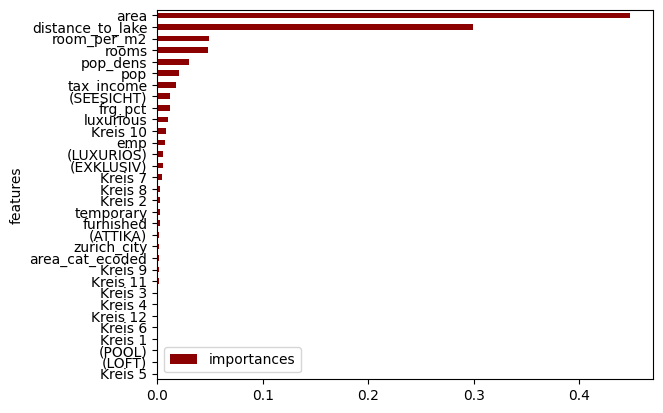

In [75]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

In [76]:
features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded', 'zurich_city']
model_performance(features, df)
# Now using distance_to_lake in model training!

CV results RMSE: [-561. -621. -558. -742. -627.]
Mean RMSE: -621.8


<Axes: ylabel='features'>

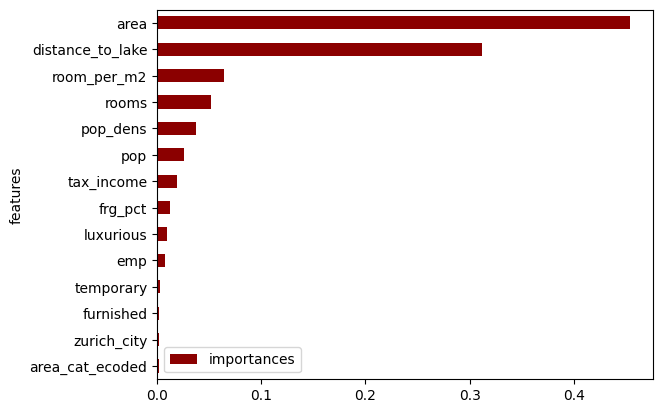

In [77]:
# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

cols = random_forest_model.feature_names_in_

# Derive feature importance from random forest
importances = random_forest_model.feature_importances_
std         = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances',
           x='features', 
           color='darkred')

### Error analysis

In [78]:
# get all predictions for the training set.

# train random_forest_model = RandomForestRegressor()
random_forest_model = RandomForestRegressor(random_state=42)

# Fit the model
random_forest_model.fit(df[features], df.price)

price_prediction = random_forest_model.predict(df[features])
df_with_residual = pd.DataFrame(df[features], columns=df[features].columns, copy=True)
df_with_residual['recidual (error)'] = np.abs(price_prediction - df.price)
df_with_residual['price'] = df.price
df_with_residual['predicted_price'] = price_prediction
print(df_with_residual.head())
# Add text, postalcode and town name
# we use join instead of merge, because we 'join' on the index column and do not perform a merge using a specific column
df_with_residual = df_with_residual.join(df[['description_raw', 'bfs_name', 'postalcode', 'town']])

   distance_to_lake  rooms  area    pop     pop_dens    frg_pct     emp  \
0         26.263341    3.0    49  12286  1221.272366  24.841283  5053.0   
1         26.873544    3.0   111  12286  1221.272366  24.841283  5053.0   
2         26.728637    3.0    58  12286  1221.272366  24.841283  5053.0   
3         26.258684    4.0   118  12286  1221.272366  24.841283  5053.0   
4         26.990462    3.0    66  12286  1221.272366  24.841283  5053.0   

   tax_income  room_per_m2  luxurious  temporary  furnished  area_cat_ecoded  \
0       66676        16.33          0          0          0              0.0   
1       66676        37.00          0          0          0              1.0   
2       66676        19.33          0          0          0              2.0   
3       66676        29.50          0          0          0              1.0   
4       66676        22.00          0          0          0              2.0   

   zurich_city  recidual (error)  price  predicted_price  
0        

In [79]:
# check which location has the largest errors.
df_with_residual[(df_with_residual['recidual (error)'] > 500)].groupby(['pop', 'bfs_name']).size().sort_values(ascending=False)

pop     bfs_name     
39647   Zürich           5
50950   Zürich           5
17860   Zürich           4
41411   Zürich           4
113173  Winterthur       3
13067   Zollikon         2
29944   Zürich           2
37639   Zürich           2
4840    Oetwil am See    1
6485    Fehraltorf       1
16841   Wallisellen      1
18139   Thalwil          1
27746   Dietikon         1
33537   Zürich           1
59841   Zürich           1
78801   Zürich           1
dtype: int64

In [80]:

df_with_residual[(df_with_residual['recidual (error)'] > 800)].to_csv('data_with_large_residuals.csv', 
          sep=",", 
          encoding='utf-8',
          index=False)

## Find the best parameters
- GridSearch
- RandomSearchCV

In [81]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 500, 1000]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3,
scoring='neg_root_mean_squared_error', verbose = 2)
grid_search.fit(df[features], df.price)

# get best estimator:
grid_search.best_estimator_


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=100; total time=   0.2s
[CV] END ...................................n_estimators=500; total time=   0.9s
[CV] END ...................................n_estimators=500; total time=   0.9s
[CV] END ...................................n_estimators=500; total time=   0.8s
[CV] END ..................................n_estimators=1000; total time=   1.8s
[CV] END ..................................n_estimators=1000; total time=   1.7s
[CV] END ..................................n_estimators=1000; total time=   1.6s


RandomForestRegressor(n_estimators=500, random_state=42)

In [82]:
features = ['distance_to_lake', 'rooms', 'area', 'pop', 'pop_dens', 'frg_pct', 'emp', 'tax_income', 'room_per_m2', 'luxurious', 'temporary', 'furnished', 'area_cat_ecoded', 'zurich_city']
model_performance(features, df)

print('After GridSearch')
model_performance(features, df, RandomForestRegressor(n_estimators=1000, random_state=42))


# Now using distance_to_lake in model training!

CV results RMSE: [-561. -621. -558. -742. -627.]
Mean RMSE: -621.8
After GridSearch
CV results RMSE: [-560. -615. -561. -741. -620.]
Mean RMSE: -619.4


In [83]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'max_depth': [90, 100, 110],
'max_features': [6, 9],
'min_samples_leaf': [4, 5],
'min_samples_split': [10, 12],
'n_estimators': [100, 500, 1000]
}

clf = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, random_state=0, n_iter=10, verbose=2)
search = clf.fit(df[features], df.price)

print(search.best_estimator_)
model_performance(features, df, search.best_estimator_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   1.0s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.9s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.9s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.8s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.8s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.1s
[CV] END max_depth=100, max_features=6, min_samples_leaf=4, min_samples_split=12, n_estimators=100; t

In [84]:
df.to_csv('apartments_data.csv')

In [94]:
# Features definieren (diese Liste wurde vorher angepasst)
features = ['distance_to_lake', 'rooms', 'area',
            'luxurious', 'temporary', 'furnished', 'luxurios', 'pool', 'seesicht', 
            'exklusiv', 'attika', 'loft']

# Stelle sicher, dass die Features existieren!
print("Vorhandene Spalten:", df.columns)

# Daten für das Modell vorbereiten
X = df[features]  # X ist jetzt definiert
y = df['price']   # y ist jetzt definiert


Vorhandene Spalten: Index(['bfs_number', 'rooms', 'area', 'price', 'postalcode', 'address', 'town',
       'description_raw', 'bfs_name', 'pop', 'pop_dens', 'frg_pct', 'emp',
       'tax_income', 'lat', 'lon', 'x', 'y', 'distance_to_lake', 'luxurious',
       'temporary', 'furnished', 'luxurios', 'pool', 'seesicht', 'exklusiv',
       'attika', 'loft', 'room_per_m2', 'price_per_m2', 'area_cat',
       'area_cat_ecoded', '(LOFT)', '(SEESICHT)', '(LUXURIÖS)', '(POOL)',
       '(ATTIKA)', '(EXKLUSIV)', 'Kreis 6', 'Kreis 11', 'Kreis 12', 'Kreis 10',
       'Kreis 4', 'Kreis 1', 'Kreis 9', 'Kreis 5', 'Kreis 7', 'Kreis 3',
       'Kreis 2', 'Kreis 8', 'zurich_city'],
      dtype='object')


# Gradio UI for prediction

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import joblib

# Daten splitten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modell trainieren
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Modell speichern
joblib.dump(model, "apartment_price_model.pkl")
print("✅ Modell gespeichert!")


✅ Modell gespeichert!


In [96]:
import joblib

# Load the trained model
model = joblib.load("apartment_price_model.pkl")
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [97]:
import gradio as gr
import numpy as np
import joblib

# Load the trained model
model = joblib.load("apartment_price_model.pkl")
print("✅ Model loaded successfully!")

# Define the prediction function
def predict_price(rooms, area, distance_to_lake, luxurious, temporary, furnished, 
                  luxurios, pool, seesicht, exklusiv, attika, loft):
    try:
        # Match exactly the 12 features used in model training
        input_data = np.array([[distance_to_lake, rooms, area, luxurious, temporary, furnished, 
                                luxurios, pool, seesicht, exklusiv, attika, loft]])
        
        prediction = model.predict(input_data)
        return f"Estimated Price: {prediction[0]:,.2f} CHF"
    
    except Exception as e:
        return f"Error: {str(e)}"

# Define Gradio UI
iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Rooms"),
        gr.Number(label="Area (m²)"),
        gr.Number(label="Distance to Lake Zurich (km)"),
        gr.Checkbox(label="Luxurious"),
        gr.Checkbox(label="Temporary"),
        gr.Checkbox(label="Furnished"),
        gr.Checkbox(label="Luxurious (LUXURIÖS)"),
        gr.Checkbox(label="Pool"),
        gr.Checkbox(label="Seesicht"),
        gr.Checkbox(label="Exklusiv"),
        gr.Checkbox(label="Attika"),
        gr.Checkbox(label="Loft")
    ],
    outputs=gr.Textbox(label="Predicted Apartment Price"),
    title="Apartment Price Estimator",
    description="Enter the apartment details and click 'Submit' to get an estimated price prediction.",
    live=False  # Ensures a Submit button appears
)

# Launch Gradio App
iface.launch()


✅ Model loaded successfully!
* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
